In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv('grocery_dataset_eda.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')
df = df[(df.index >= '2004-01-01') & (df.index <= '2024-12-31')]

In [3]:
df.index

DatetimeIndex(['2004-01-31', '2004-02-29', '2004-03-31', '2004-04-30',
               '2004-05-31', '2004-06-30', '2004-07-31', '2004-08-31',
               '2004-09-30', '2004-10-31',
               ...
               '2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30',
               '2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31',
               '2024-11-30', '2024-12-31'],
              dtype='datetime64[ns]', name='date', length=252, freq=None)

In [4]:
# Count total missing values per column
missing_counts = df.isna().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts

Series([], dtype: int64)

In [5]:
# Count infs
inf_counts = df.isin([np.inf, -np.inf]).sum()
inf_counts = inf_counts[inf_counts>0]
inf_counts

Series([], dtype: int64)

In [6]:
df['grocery_sales_lag1']

date
2004-01-31    35808.0
2004-02-29    36402.0
2004-03-31    35890.0
2004-04-30    36365.0
2004-05-31    36312.0
               ...   
2024-08-31    74892.0
2024-09-30    74559.0
2024-10-31    75140.0
2024-11-30    75403.0
2024-12-31    75235.0
Name: grocery_sales_lag1, Length: 252, dtype: float64

### OLS ###

In [7]:
# Define independent (X) and dependent (y) variables
X = df[['grocery_sales_lag1', 'cpi_fah', 'rdi', 'covid1', 'covid2']]
y = df['grocery_sales']

# Add a constant for intercept
X = sm.add_constant(X)

# Fit OLS (Ordinary Least Squares) regression model
model_sm = sm.OLS(y, X).fit()

# Print detailed statistical summary
print(model_sm.summary())

# merge fitted values onto dh.  We don't need to merge because the row indices are the same
df['forecasted'] = model_sm.fittedvalues
df['residuals'] = model_sm.resid

                            OLS Regression Results                            
Dep. Variable:          grocery_sales   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.968e+04
Date:                Sat, 15 Mar 2025   Prob (F-statistic):               0.00
Time:                        10:05:30   Log-Likelihood:                -1841.0
No. Observations:                 252   AIC:                             3694.
Df Residuals:                     246   BIC:                             3715.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -244.3625    484

In [8]:
# All stored in sm_model behind the scenes
print(dir(model_sm))

['HC0_se', 'HC1_se', 'HC2_se', 'HC3_se', '_HCCM', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abat_diagonal', '_cache', '_data_attr', '_data_in_cache', '_get_robustcov_results', '_get_wald_nonlinear', '_is_nested', '_transform_predict_exog', '_use_t', '_wexog_singular_values', 'aic', 'bic', 'bse', 'centered_tss', 'compare_f_test', 'compare_lm_test', 'compare_lr_test', 'condition_number', 'conf_int', 'conf_int_el', 'cov_HC0', 'cov_HC1', 'cov_HC2', 'cov_HC3', 'cov_kwds', 'cov_params', 'cov_type', 'df_model', 'df_resid', 'diagn', 'eigenvals', 'el_test', 'ess', 'f_pvalue', 'f_test', 'fittedvalues', 'fvalue', 'get_influence', 'get_prediction', 'get_robustcov_results', 'info_crit

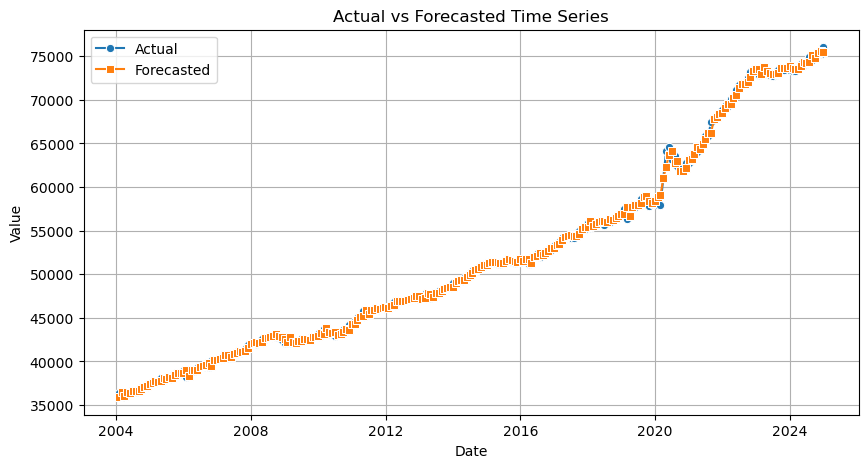

In [9]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x=df.index, y='grocery_sales', label='Actual', marker='o')
sns.lineplot(data=df, x=df.index, y='forecasted', label='Forecasted', marker='s')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Forecasted Time Series')
plt.legend()
plt.grid(True)

plt.show()


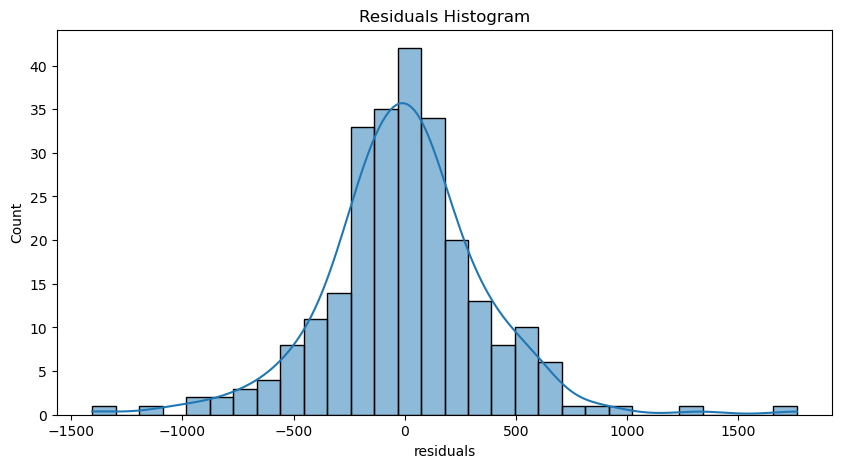

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(df["residuals"], bins=30, kde=True)
plt.title('Residuals Histogram')
plt.show()

<Figure size 1000x500 with 0 Axes>

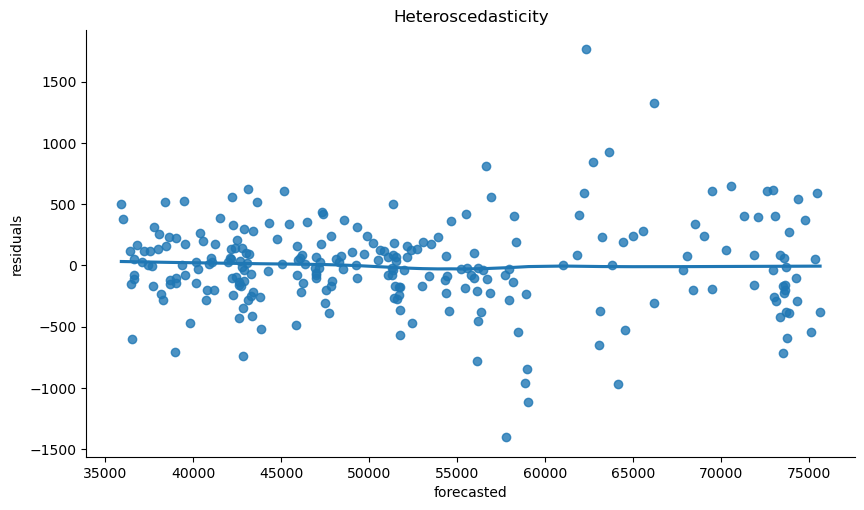

In [11]:
plt.figure(figsize=(10, 5))
sns.lmplot(x="forecasted", y="residuals", data=df, lowess=True, aspect=1.75, height=5)
plt.title('Heteroscedasticity')
plt.show()

In [12]:
# Step 1: Add a constant column (intercept)
X = sm.add_constant(X)

# Step 2: Initialize an empty list to store VIF values
vif_list = []

# Step 3: Loop through each feature and compute VIF
for i in range(X.shape[1]):  # Loop over each column index
    vif_value = variance_inflation_factor(X.values, i)  # Compute VIF for the column
    vif_list.append((X.columns[i], vif_value))  # Store (Feature Name, VIF Value)

# Step 4: Convert results into a DataFrame
vif_data = pd.DataFrame(vif_list, columns=["Feature", "VIF"])
vif_data

,Feature,VIF
0,const,4.449841e+02
1,grocery_sales_lag1,5.544330e+01
2,cpi_fah,2.900301e+05
3,rdi,5.714285e+01
4,covid1,4.947980e+08
5,covid2,4.903806e+08


In [13]:
# Ensure X includes the same predictors used in training

# Get predictions and confidence intervals
predictions = model_sm.get_prediction(X)
pred_summary = predictions.summary_frame(alpha=0.05)  # 95% CI

# Store forecasted values
df['forecasted'] = pred_summary['mean']  # Mean prediction
df['se_mean'] = pred_summary['mean_se']  # SE of the mean

# ✅ Corrected: Use 'obs_ci_lower' & 'obs_ci_upper' for observation CI
df['lower_bound_obs'] = pred_summary['obs_ci_lower']
df['upper_bound_obs'] = pred_summary['obs_ci_upper']

# ✅ Compute SE of the estimate (obs_se) using the correct columns
df['se_obs'] = (df['upper_bound_obs'] - df['lower_bound_obs']) / (2 * 1.96)  # 95% CI

# ✅ Store mean confidence interval bounds
df['lower_bound'] = pred_summary['mean_ci_lower']
df['upper_bound'] = pred_summary['mean_ci_upper']

# Show first few rows
df[['forecasted', 'se_mean', 'se_obs', 'lower_bound', 'upper_bound', 'lower_bound_obs', 'upper_bound_obs']].head()

,forecasted,se_mean,se_obs,lower_bound,upper_bound,lower_bound_obs,upper_bound_obs
date,,,,,,,
2004-01-31,35901.772075,50.792831,369.819822,35801.727763,36001.816388,35176.925225,36626.618925
2004-02-29,36495.578709,54.514343,370.354523,36388.204305,36602.953113,35769.683845,37221.473574
2004-03-31,35986.896967,48.599925,369.522109,35891.171921,36082.622012,35262.633633,36711.160300
2004-04-30,36464.333274,51.020546,369.851475,36363.840443,36564.826106,35739.424383,37189.242166
2004-05-31,36407.978155,45.351768,369.104870,36318.650856,36497.305455,35684.532609,37131.423701


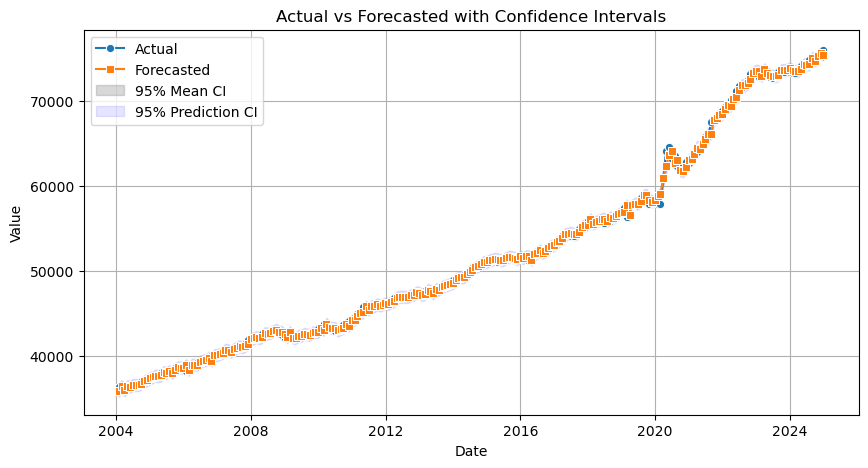

In [14]:
# Define the start and end date for filtering
#start_date = '2021-01-01'
#end_date = '2024-12-31'

# Filter the DataFrame to only include the desired months
#df_subset = df.loc[start_date:end_date]
#df_subset

#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df, x=df.index, y=df['grocery_sales'], label='Actual', marker='o')
sns.lineplot(data=df, x=df.index, y='forecasted', label='Forecasted', marker='s')

plt.fill_between(df.index, df['lower_bound'], df['upper_bound'], color='gray', alpha=0.3, label="95% Mean CI")
plt.fill_between(df.index, df['lower_bound_obs'], df['upper_bound_obs'], color='blue', alpha=0.1, label="95% Prediction CI")

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Forecasted with Confidence Intervals')
plt.legend()
plt.grid(True)

plt.show()


### Forward Forecast ###

In [15]:
# # Define monthly growth rates
# cpi_growth_rate = 1.016  # 1.6% monthly increase
# home_price_growth_rate = 1.01  # 2% monthly increase

# # Define forecast period (Feb - Dec)
# future_dates = pd.date_range(start="2024-02-01", end="2024-12-01", freq='MS')

# # Create a DataFrame for projections
# df_future = pd.DataFrame(index=future_dates)


In [16]:
# # Get the last known forecasted grocery sales value
# last_sales_value = df['forecasted'].iloc[-1]  # Last available forecasted sales
# last_cpi_fah = df['cpi_fah'].iloc[-1]  # Last known CPI-FAH value
# last_home_price = df['home_price'].iloc[-1]  # Last known home price

In [17]:
# # Generate forecast periods (Feb to Dec)
# forecast_periods = np.arange(1, len(df_future) + 1)  # Convert to a NumPy array

# # Correct the exponential growth calculation
# df_future['cpi_fah'] = last_cpi_fah * (cpi_growth_rate ** forecast_periods)
# df_future['home_price'] = last_home_price * (home_price_growth_rate ** forecast_periods)

In [18]:
df.index

DatetimeIndex(['2004-01-31', '2004-02-29', '2004-03-31', '2004-04-30',
               '2004-05-31', '2004-06-30', '2004-07-31', '2004-08-31',
               '2004-09-30', '2004-10-31',
               ...
               '2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30',
               '2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31',
               '2024-11-30', '2024-12-31'],
              dtype='datetime64[ns]', name='date', length=252, freq=None)

### RIDGE ###


In [19]:
# Define Features (X) and Target (y)
X = df[['grocery_sales_lag1', 'cpi_fah', 'home_price', 'rdi', 'covid1', 'covid2']]
y = df['grocery_sales'] 

# Handle missing values (fill with median)
X = X.fillna(X.median())

# Standardize features (important for Ridge Regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardize the features

# Convert back to a DataFrame to retain column names
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

# Define training data (2004-2023) and test data (2024)
X_train = X_scaled_df.loc[:'2023-12-31']  # Features for 2004-2023
y_train = y.loc[:'2023-12-31']            # Target for 2004-2023

X_test = X_scaled_df.loc['2024-01-31':]   # Features for 2024
y_test = y.loc['2024-01-31':]             # Target for 2024

# Print train/test sizes to verify
print(f"Train Size: {X_train.shape}, Test Size: {X_test.shape}")


Train Size: (240, 6), Test Size: (12, 6)


In [20]:
# Define a range of alpha values to test
alpha_values = np.logspace(-3, 3, 100)  # Values from 0.001 to 1000

# Ridge Regression with cross-validation
ridge_cv = RidgeCV(alphas=alpha_values, store_cv_results=True)
ridge_cv.fit(X_train, y_train)

# Best alpha value selected
best_alpha = ridge_cv.alpha_
print(f"🔍 Best Alpha Found: {best_alpha}")

# Train Ridge model with best alpha
ridge = RidgeCV(alphas=[best_alpha])
ridge.fit(X_train, y_train)

# Predict for training period (2004-2023) and convert to Pandas Series
ridge_train_forecast = pd.Series(ridge.predict(X_train), index=y_train.index, name="Ridge_Train_Forecast")

# Predict for test period (2024) and convert to Pandas Series
ridge_test_forecast = pd.Series(ridge.predict(X_test), index=y_test.index, name="Ridge_Forecast")


🔍 Best Alpha Found: 0.30538555088334157


In [21]:
ridge_coefs = pd.DataFrame({
    "Feature": ['grocery_sales_lag1', 'cpi_fah', 'home_price', 'rdi', 'covid1', 'covid2'],
    "Coefficient": ridge.coef_
}).sort_values(by="Coefficient", ascending=False)

print("📌 Ridge Regression Coefficients:")
print(ridge_coefs)


📌 Ridge Regression Coefficients:
              Feature   Coefficient
0  grocery_sales_lag1  11060.136075
3                 rdi    650.834889
2          home_price    174.973503
1             cpi_fah    -91.305109
4              covid1   -210.233079
5              covid2   -215.686563


In [22]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def create_forecast_results_df(y_train, y_test, train_forecast, test_forecast):
    """
    Creates a standardized forecast DataFrame and computes performance metrics.

    Parameters:
        y_train (pd.Series): Actual sales in the training period
        y_test (pd.Series): Actual sales in the test period
        train_forecast (pd.Series): Model's forecast for the training period
        test_forecast (pd.Series): Model's forecast for the test period

    Returns:
        forecast_df (pd.DataFrame): DataFrame containing actuals, forecasts, and residuals
        metrics (dict): Dictionary containing R², MSE, MAE, and MAPE
    """

    # Compute residuals
    train_residuals = y_train - train_forecast
    test_residuals = y_test - test_forecast

    # Force missing values to NaN instead of None
    forecast_df = pd.DataFrame({
        "Actual_Sales": pd.concat([y_train, y_test]),
        "Train_Forecast": pd.concat([train_forecast.loc[y_train.index], pd.Series([np.nan] * len(y_test), index=y_test.index)]),
        "Test_Forecast": pd.concat([pd.Series([np.nan] * len(y_train), index=y_train.index), test_forecast]),
        "Train_Residuals": pd.concat([train_residuals, pd.Series([np.nan] * len(y_test), index=y_test.index)]),
        "Test_Residuals": pd.concat([pd.Series([np.nan] * len(y_train), index=y_train.index), test_residuals])
    }).astype(float)  # 🔹 Ensure all columns remain float

    # Compute Performance Metrics
    metrics = {
        "Train R²": r2_score(y_train, train_forecast),
        "Test R²": r2_score(y_test, test_forecast),
        "Train MSE": mean_squared_error(y_train, train_forecast),
        "Test MSE": mean_squared_error(y_test, test_forecast),
        "Train MAE": mean_absolute_error(y_train, train_forecast),
        "Test MAE": mean_absolute_error(y_test, test_forecast),
        "Train MAPE": np.mean(np.abs((y_train - train_forecast) / y_train)) * 100,
        "Test MAPE": np.mean(np.abs((y_test - test_forecast) / y_test)) * 100
    }

    return forecast_df, metrics



In [23]:
# Generate Ridge forecast DataFrame with metrics
ridge_forecast_df, ridge_metrics = create_forecast_results_df(
    y_train = y_train,
    y_test = y_test,
    train_forecast=ridge_train_forecast,
    test_forecast=ridge_test_forecast
)

# Print first few rows of the forecast results
print(ridge_forecast_df.tail(12))

# Print Ridge Regression performance metrics
print("📊 Ridge Regression Performance Metrics:")
for key, value in ridge_metrics.items():
    print(f"{key}: {value:.2f}")


            Actual_Sales  Train_Forecast  Test_Forecast  Train_Residuals  \
date                                                                       
2024-01-31       73296.0             NaN   73606.742926              NaN   
2024-02-29       73341.0             NaN   73445.736568              NaN   
2024-03-31       73617.0             NaN   73497.713011              NaN   
2024-04-30       74099.0             NaN   73761.788963              NaN   
2024-05-31       74024.0             NaN   74238.185607              NaN   
2024-06-30       74138.0             NaN   74166.268208              NaN   
2024-07-31       74892.0             NaN   74274.998676              NaN   
2024-08-31       74559.0             NaN   75004.942757              NaN   
2024-09-30       75140.0             NaN   74686.228216              NaN   
2024-10-31       75403.0             NaN   75261.985027              NaN   
2024-11-30       75235.0             NaN   75523.423154              NaN   
2024-12-31  

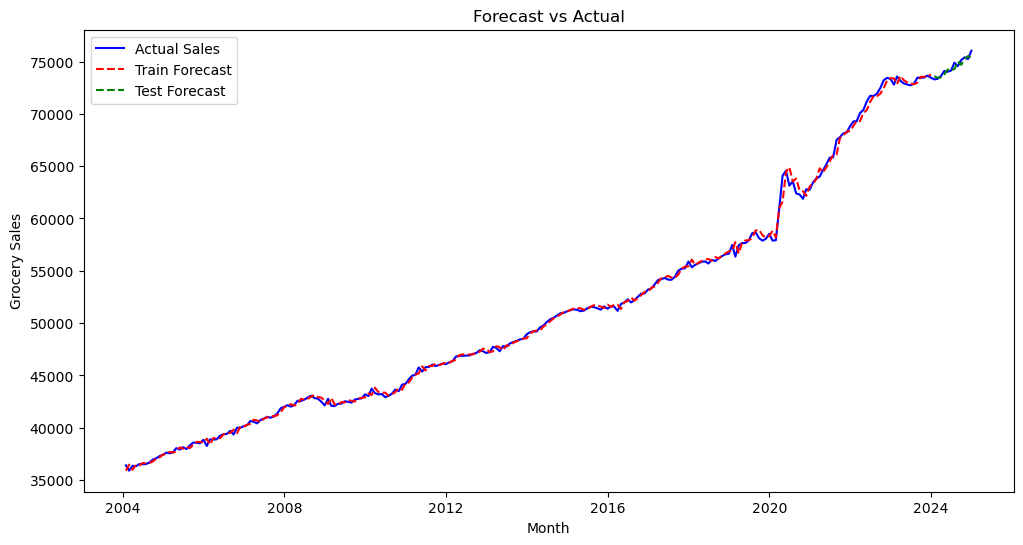

In [24]:
# Plot First-Difference Forecast vs Actual with Confidence Interval Lines
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actual, train, and test forecast
ax.plot(ridge_forecast_df.index, ridge_forecast_df['Actual_Sales'], label="Actual Sales", color="blue")
ax.plot(ridge_forecast_df.index, ridge_forecast_df['Train_Forecast'], label="Train Forecast", color="red", linestyle="dashed")
ax.plot(ridge_forecast_df.index, ridge_forecast_df['Test_Forecast'], label="Test Forecast", color="green", linestyle="dashed")

# Formatting
ax.set_xlabel("Month")
ax.set_ylabel("Grocery Sales")
ax.set_title("Forecast vs Actual")
ax.legend()

plt.show()

In [25]:
df.index

DatetimeIndex(['2004-01-31', '2004-02-29', '2004-03-31', '2004-04-30',
               '2004-05-31', '2004-06-30', '2004-07-31', '2004-08-31',
               '2004-09-30', '2004-10-31',
               ...
               '2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30',
               '2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31',
               '2024-11-30', '2024-12-31'],
              dtype='datetime64[ns]', name='date', length=252, freq=None)

### OLS ###

In [26]:
from sklearn.linear_model import LinearRegression

# Define training data (2004-2023) and test data (2024)
X_train = X_scaled_df.loc[:'2023-12-31']  # Features for 2004-2023
y_train = y.loc[:'2023-12-31']            # Target for 2004-2023

X_test = X_scaled_df.loc['2024-01-31':]   # Features for 2024
y_test = y.loc['2024-01-31':]             # Target for 2024

# Train standard linear regression model
lin_reg = LinearRegression().fit(X_train, y_train)

# Predict for training period (2004-2023) and convert to Pandas Series
ols_train_forecast = pd.Series(lin_reg.predict(X_train), index=y_train.index, name="OLS_Train_Forecast")

# Predict for test period (2024) and convert to Pandas Series
ols_test_forecast = pd.Series(lin_reg.predict(X_test), index=y_test.index, name="OLS_Test_Forecast")

In [27]:
# Generate Ridge forecast DataFrame with metrics
ols_forecast_df, ols_metrics = create_forecast_results_df(
    y_train = y_train,
    y_test = y_test,
    train_forecast=ols_train_forecast,
    test_forecast=ols_test_forecast
)

# Print first few rows of the forecast results
print(ols_forecast_df.tail(12))

# Print Ridge Regression performance metrics
print("📊 OLS Regression Performance Metrics:")
for key, value in ols_metrics.items():
    print(f"{key}: {value:.2f}")

            Actual_Sales  Train_Forecast  Test_Forecast  Train_Residuals  \
date                                                                       
2024-01-31       73296.0             NaN   73745.812709              NaN   
2024-02-29       73341.0             NaN   73585.597628              NaN   
2024-03-31       73617.0             NaN   73642.163309              NaN   
2024-04-30       74099.0             NaN   73915.202641              NaN   
2024-05-31       74024.0             NaN   74397.225580              NaN   
2024-06-30       74138.0             NaN   74326.642758              NaN   
2024-07-31       74892.0             NaN   74436.950499              NaN   
2024-08-31       74559.0             NaN   75171.803460              NaN   
2024-09-30       75140.0             NaN   74848.362487              NaN   
2024-10-31       75403.0             NaN   75423.942564              NaN   
2024-11-30       75235.0             NaN   75684.175412              NaN   
2024-12-31  

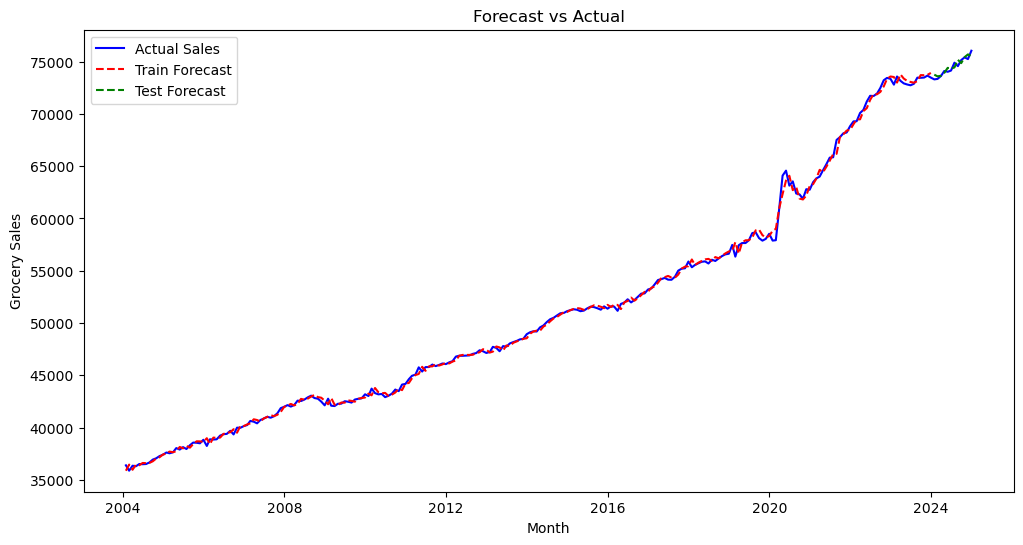

In [28]:
# Plot First-Difference Forecast vs Actual with Confidence Interval Lines
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actual, train, and test forecast
ax.plot(ols_forecast_df.index, ols_forecast_df['Actual_Sales'], label="Actual Sales", color="blue")
ax.plot(ols_forecast_df.index, ols_forecast_df['Train_Forecast'], label="Train Forecast", color="red", linestyle="dashed")
ax.plot(ols_forecast_df.index, ols_forecast_df['Test_Forecast'], label="Test Forecast", color="green", linestyle="dashed")

# Formatting
ax.set_xlabel("Month")
ax.set_ylabel("Grocery Sales")
ax.set_title("Forecast vs Actual")
ax.legend()

plt.show()

In [29]:
df.index

DatetimeIndex(['2004-01-31', '2004-02-29', '2004-03-31', '2004-04-30',
               '2004-05-31', '2004-06-30', '2004-07-31', '2004-08-31',
               '2004-09-30', '2004-10-31',
               ...
               '2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30',
               '2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31',
               '2024-11-30', '2024-12-31'],
              dtype='datetime64[ns]', name='date', length=252, freq=None)

### ARIMA

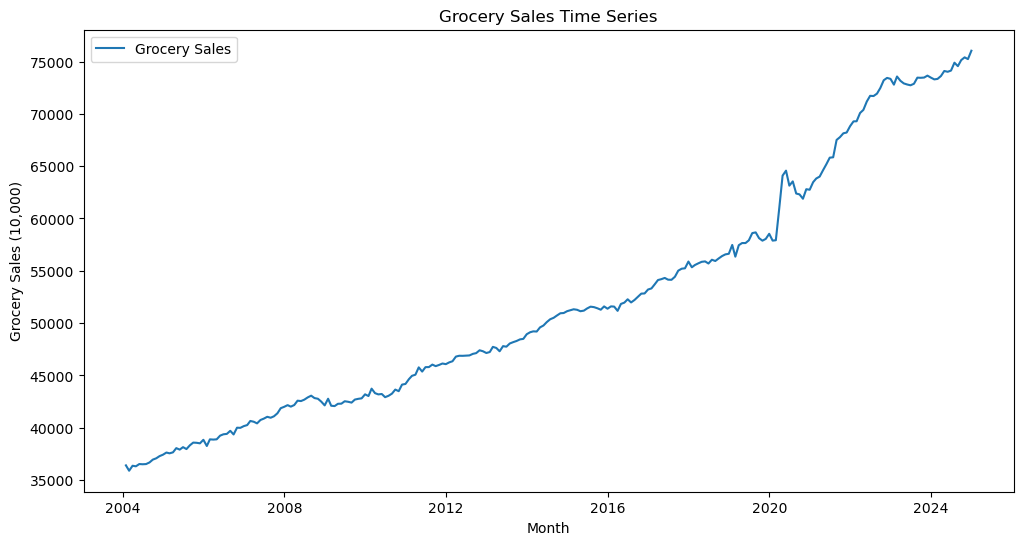

In [30]:
# Plot Grocery Sales Time Series
fig, ax = plt.subplots(figsize=(12, 6))  # Create figure and axis objects
ax.plot(df.index, df["grocery_sales"], label="Grocery Sales")  # Plot data

# Formatting
ax.set_xlabel("Month")
ax.set_ylabel("Grocery Sales (10,000)")
ax.set_title("Grocery Sales Time Series")
ax.legend()

plt.show()

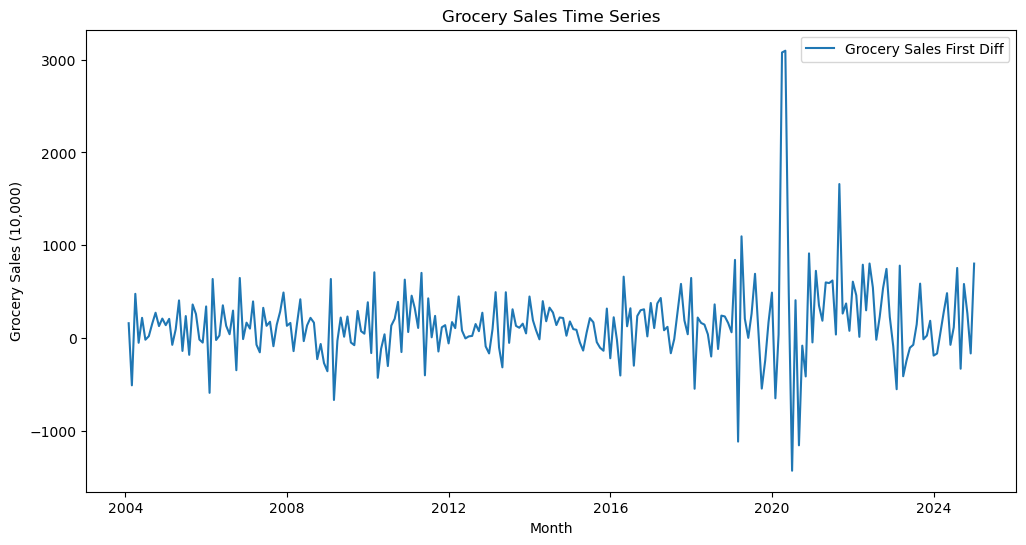

In [31]:
# calculate first difference and then replace the NaN created by the difference function
df["grocery_sales"] = df["grocery_sales"].asfreq("ME")
df["grocery_sales_diff"] = df["grocery_sales"].diff()
df = df.fillna(df.mean())  # Replace NaN with mean

# Plot Grocery Sales Time Series
fig, ax = plt.subplots(figsize=(12, 6))  # Create figure and axis objects
ax.plot(df.index, df["grocery_sales_diff"], label="Grocery Sales First Diff")  # Plot data

# Formatting
ax.set_xlabel("Month")
ax.set_ylabel("Grocery Sales (10,000)")
ax.set_title("Grocery Sales Time Series")
ax.legend()

plt.show()

In [32]:
# Function to perform ADF test
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    
    if result[1] < 0.05:
        print("The series is stationary (reject H0). No differencing needed.")
    else:
        print("The series is NOT stationary (fail to reject H0). Differencing is needed.")

# Apply ADF test on grocery sales
adf_test(df["grocery_sales"])  # Make sure to use the correct column name


ADF Statistic: 1.8062709806766992
p-value: 0.9983613737832907
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}
The series is NOT stationary (fail to reject H0). Differencing is needed.


In [33]:
df = df.fillna(df.mean())

# Function to perform ADF test
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    
    if result[1] < 0.05:
        print("The series is stationary (reject H0). No differencing needed.")
    else:
        print("The series is NOT stationary (fail to reject H0). Differencing is needed.")

# Apply ADF test on grocery sales
adf_test(df["grocery_sales_diff"])  # Make sure to use the correct column name


ADF Statistic: -14.987866386606937
p-value: 1.1367814768813815e-27
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}
The series is stationary (reject H0). No differencing needed.


In [34]:
# Set month format
df = df.asfreq("ME")

# Auto-ARIMA to find best p, d, q
auto_model = auto_arima(df["grocery_sales_diff"],  
                        seasonal=False,  # No seasonality since we deseasonalized
                        trace=True,  
                        suppress_warnings=True)

# Print best order
print("Best ARIMA Order:", auto_model.order)

Performing stepwise search to minimize aic


C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\e

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3927.454, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3864.770, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3925.460, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3848.782, Time=0.03 sec


C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\e

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3827.415, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3823.636, Time=0.12 sec


C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=3823.364, Time=0.20 sec


C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec


C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=3821.382, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=3821.651, Time=0.09 sec


C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0]             : AIC=3776.096, Time=0.58 sec


C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3775.655, Time=0.41 sec


C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3773.761, Time=0.37 sec


C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3773.982, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=3825.431, Time=0.07 sec


C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3846.791, Time=0.05 sec


C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.48 sec


C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.62 sec


C:\Users\erick\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 5.983 seconds
Best ARIMA Order: (3, 1, 1)


In [35]:
# Ensure the original series has a monthly frequency BEFORE differencing
df["grocery_sales"] = df["grocery_sales"].asfreq('ME')

# Create first-differenced series
df["grocery_sales_diff"] = df["grocery_sales"].diff()
df = df.fillna(df.mean())

# Split into training and test sets
train_diff = df.loc[:'2023-12-31', "grocery_sales_diff"]
test_diff = df.loc['2024-01-31':, "grocery_sales_diff"]

# Ensure frequency is set properly
train_diff = train_diff.asfreq("ME")
test_diff = test_diff.asfreq("ME")

# Define y_train and y_test as the original (non-differenced) values
y_train = df.loc[:'2023-12-31', "grocery_sales"]
y_test = df.loc['2024-01-31':, "grocery_sales"]

# Ensure the frequency of y_train and y_test matches
y_train = y_train.asfreq('ME')
y_test = y_test.asfreq('ME')

# Fit ARIMA model on first-differenced training data
model_diff = ARIMA(train_diff, order=(3,1,1))  # d=0 since we manually differenced
arima_diff = model_diff.fit()

In [36]:
# Generate ARIMA training forecasts using fitted values
train_forecast_diff = arima_diff.fittedvalues

# Convert to Pandas Series with correct index
train_forecast_diff = pd.Series(train_forecast_diff, index=y_train.index, name="Train_Forecast_Diff")

# Generate ARIMA test forecasts using integer positions
#test_forecast_diff = arima_diff.predict(start=test_diff.index[0], end=test_diff.index[-1])
test_forecast_diff = arima_diff.predict(start=y_test.index[0], end=y_test.index[-1])

# Convert to Pandas Series with correct index
test_forecast_diff = pd.Series(test_forecast_diff, index=y_test.index, name="Test_Forecast_Diff")

# Verify alignment
print(train_forecast_diff.shape, train_diff.shape)  # Should match
print(test_forecast_diff.shape, test_diff.shape)  # Should match



(240,) (240,)
(12,) (12,)


In [37]:
# Get the last actual value before the test period starts
last_actual_value = df.loc['2023-12-31', "grocery_sales"]

# Convert first-difference forecasts back to actual sales values
train_forecast = y_train.iloc[0] + train_forecast_diff.cumsum()
test_forecast = y_test.iloc[-1] + test_forecast_diff.cumsum()

# Print first few values to verify
print(train_forecast.head())
print(test_forecast.head())

date
2004-01-31    36402.000000
2004-02-29    36540.157124
2004-03-31    36353.101283
2004-04-30    36412.234591
2004-05-31    36489.991139
Freq: ME, Name: Train_Forecast_Diff, dtype: float64
date
2024-01-31    76258.257650
2024-02-29    76482.253067
2024-03-31    76748.314168
2024-04-30    76968.781275
2024-05-31    77186.824442
Freq: ME, Name: Test_Forecast_Diff, dtype: float64


In [38]:
print(len(y_train.index), len(train_forecast.index))  # Should be the same
print(len(y_test.index), len(test_forecast.index))  # Should be the same

240 240
12 12


In [39]:
print(train_forecast.index.equals(y_train.index))  # Should be True
print(test_forecast.index.equals(y_test.index))  # Should be True


True
True


In [40]:
# Call the function with corrected inputs
arima_forecast_df, arima_metrics = create_forecast_results_df(
     y_train = y_train,
     y_test = y_test,
     train_forecast = train_forecast,
     test_forecast = test_forecast
)

# Print first few rows of forecast results
print(arima_forecast_df.tail(12))

# Print ARIMA Performance Metrics
print("📊 ARIMA Performance Metrics:")
for key, value in arima_metrics.items():
     print(f"{key}: {value:.2f}")

            Actual_Sales  Train_Forecast  Test_Forecast  Train_Residuals  \
date                                                                       
2024-01-31       73296.0             NaN   76258.257650              NaN   
2024-02-29       73341.0             NaN   76482.253067              NaN   
2024-03-31       73617.0             NaN   76748.314168              NaN   
2024-04-30       74099.0             NaN   76968.781275              NaN   
2024-05-31       74024.0             NaN   77186.824442              NaN   
2024-06-30       74138.0             NaN   77400.043745              NaN   
2024-07-31       74892.0             NaN   77618.291102              NaN   
2024-08-31       74559.0             NaN   77837.063044              NaN   
2024-09-30       75140.0             NaN   78056.400115              NaN   
2024-10-31       75403.0             NaN   78275.183515              NaN   
2024-11-30       75235.0             NaN   78493.879419              NaN   
2024-12-31  

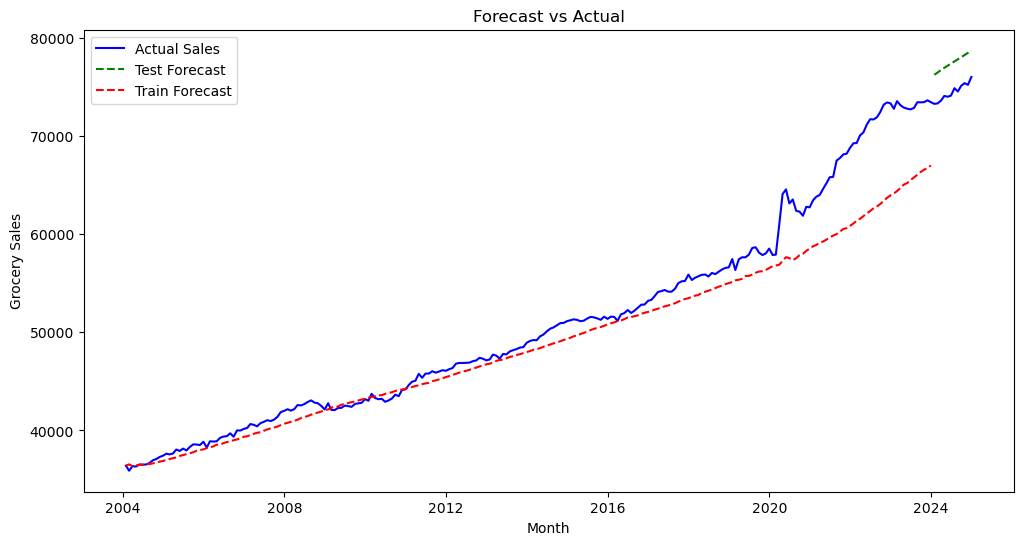

In [41]:
# Plot Forecast vs Actual with Confidence Interval Lines
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actual, train, and test forecast
ax.plot(arima_forecast_df.index, arima_forecast_df['Actual_Sales'], label="Actual Sales", color="blue")

ax.plot(arima_forecast_df.index, arima_forecast_df['Test_Forecast'], label="Test Forecast", color="green", linestyle="dashed")

ax.plot(arima_forecast_df.index, arima_forecast_df['Train_Forecast'], label="Train Forecast", color="red", linestyle="dashed")

# Formatting
ax.set_xlabel("Month")
ax.set_ylabel("Grocery Sales")
ax.set_title("Forecast vs Actual")
ax.legend()

plt.show()

In [42]:
ridge_forecast_df = ridge_forecast_df.rename(columns={'Actual_Sales':'Actual_Sales_', 'Train_Forecast':'Train_Forecast_ridge', 'Test_Forecast':'Test_Forecast_ridge'})

ols_forecast_df = ols_forecast_df.rename(columns={'Train_Forecast':'Train_Forecast_ols', 'Test_Forecast':'Test_Forecast_ols'})

arima_forecast_df = arima_forecast_df.rename(columns={'Train_Forecast':'Train_Forecast_arima', 'Test_Forecast':'Test_Forecast_arima'})

forecast_df = pd.concat([ridge_forecast_df, ols_forecast_df, arima_forecast_df], axis=1).drop(columns=['Train_Residuals','Test_Residuals', 'Actual_Sales'])
forecast_df

,Actual_Sales_,Train_Forecast_ridge,Test_Forecast_ridge,Train_Forecast_ols,Test_Forecast_ols,Train_Forecast_arima,Test_Forecast_arima
date,,,,,,,
2004-01-31,36402.0,35889.706843,NaN,35886.131617,NaN,36402.000000,NaN
2004-02-29,35890.0,36469.927213,NaN,36471.391326,NaN,36540.157124,NaN
2004-03-31,36365.0,35981.158171,NaN,35979.628973,NaN,36353.101283,NaN
2004-04-30,36312.0,36449.170193,NaN,36452.258905,NaN,36412.234591,NaN
2004-05-31,36528.0,36407.890545,NaN,36409.719759,NaN,36489.991139,NaN
...,...,...,...,...,...,...,...
2024-08-31,74559.0,NaN,75004.942757,NaN,75171.803460,NaN,77837.063044
2024-09-30,75140.0,NaN,74686.228216,NaN,74848.362487,NaN,78056.400115
2024-10-31,75403.0,NaN,75261.985027,NaN,75423.942564,NaN,78275.183515


In [43]:
forecast_df.to_csv('forecast_df.csv')

In [44]:
# Create a dictionary of model metrics
metrics_data = {
    "Model": ["Ridge", "OLS", "ARIMA"],
    "Train R²": [ridge_metrics["Train R²"], ols_metrics["Train R²"], arima_metrics["Train R²"]],
    "Test R²": [ridge_metrics["Test R²"], ols_metrics["Test R²"], arima_metrics["Test R²"]],
    "Train MSE": [ridge_metrics["Train MSE"], ols_metrics["Train MSE"], arima_metrics["Train MSE"]],
    "Test MSE": [ridge_metrics["Test MSE"], ols_metrics["Test MSE"], arima_metrics["Test MSE"]],
    "Train MAE": [ridge_metrics["Train MAE"], ols_metrics["Train MAE"], arima_metrics["Train MAE"]],
    "Test MAE": [ridge_metrics["Test MAE"], ols_metrics["Test MAE"], arima_metrics["Test MAE"]],
    "Train MAPE": [ridge_metrics["Train MAPE"], ols_metrics["Train MAPE"], arima_metrics["Train MAPE"]],
    "Test MAPE": [ridge_metrics["Test MAPE"], ols_metrics["Test MAPE"], arima_metrics["Test MAPE"]]
}

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save as CSV for Power BI
metrics_df.to_csv("model_performance_metrics.csv", index=False)

